In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df= pd.read_csv('E:/thesis files/Pre intervention international.csv')

In [5]:
df['Date']=pd.to_datetime(df['Date'])
df=df.set_index(df['Date'])

In [6]:
del df['Date']

In [11]:
df['AirPassengers']=(df['International Passengers'])/1000000

In [13]:
del df['International Passengers']

In [14]:
df.head()

,AirPassengers
Date,
2010-01-01,6.816044
2010-02-01,6.014415
2010-03-01,7.531317
2010-04-01,6.941422
2010-05-01,7.402599


In [15]:
pre_covid=df

<AxesSubplot:xlabel='Date'>

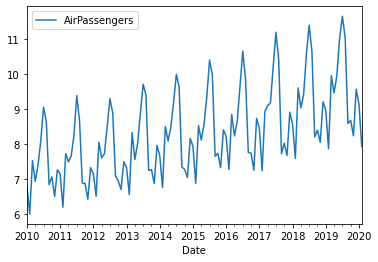

In [16]:
pre_covid.plot()

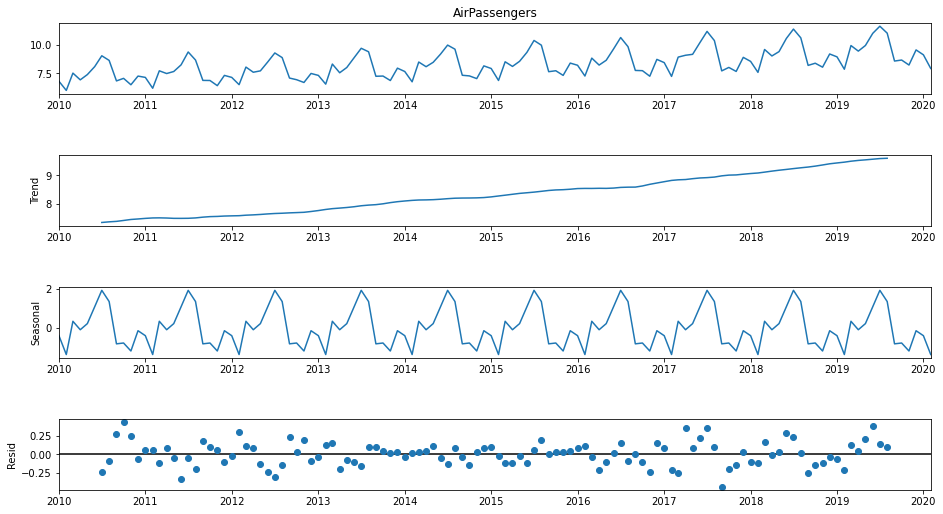

In [17]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(pre_covid.AirPassengers,model='add',period=12);
fig=seas_d.plot()
fig.set_size_inches(15, 8)
plt.show()

In [18]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean() # 24 hours on each day
    rolstd = timeseries.rolling(window=12).std()
   

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

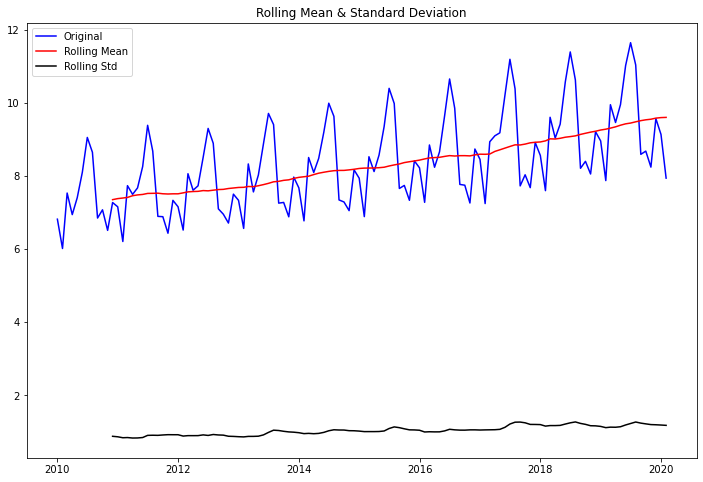

Results of Dickey-Fuller Test:
Test Statistic                   2.166831
p-value                          0.998854
#Lags Used                      12.000000
Number of Observations Used    109.000000
Critical Value (1%)             -3.491818
Critical Value (5%)             -2.888444
Critical Value (10%)            -2.581120
dtype: float64


In [19]:
test_stationarity(pre_covid.AirPassengers)

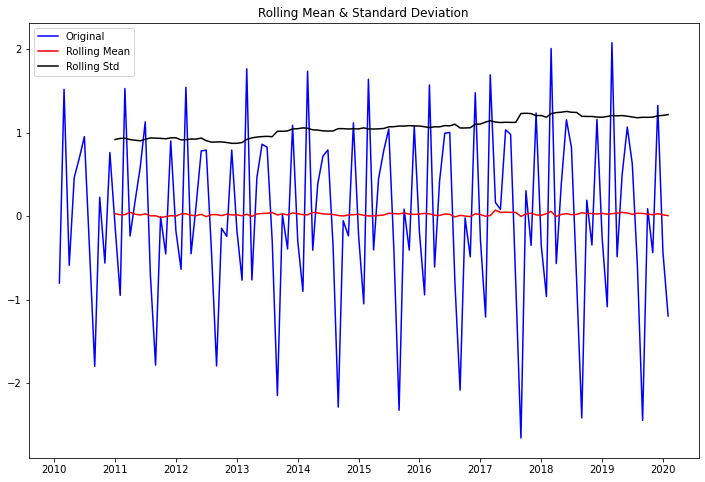

Results of Dickey-Fuller Test:
Test Statistic                  -3.598808
p-value                          0.005784
#Lags Used                      13.000000
Number of Observations Used    107.000000
Critical Value (1%)             -3.492996
Critical Value (5%)             -2.888955
Critical Value (10%)            -2.581393
dtype: float64


In [20]:
pre_covid['first_difference'] = pre_covid.AirPassengers - pre_covid.AirPassengers.shift(1)  
test_stationarity(pre_covid.first_difference.dropna(inplace=False))

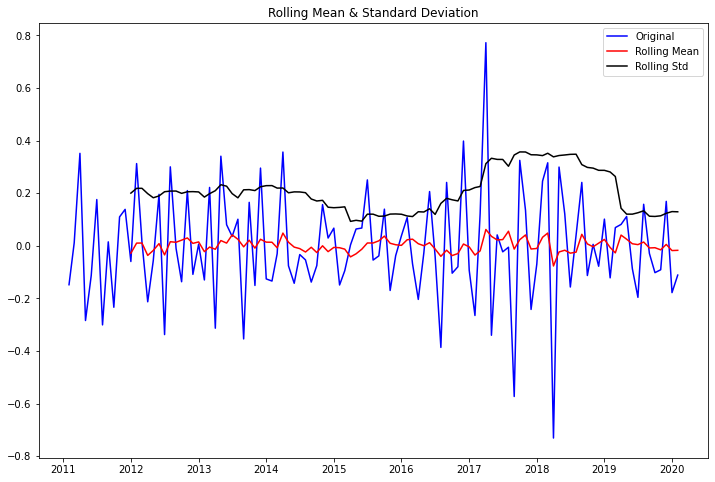

Results of Dickey-Fuller Test:
Test Statistic                 -4.227848
p-value                         0.000591
#Lags Used                     12.000000
Number of Observations Used    96.000000
Critical Value (1%)            -3.500379
Critical Value (5%)            -2.892152
Critical Value (10%)           -2.583100
dtype: float64


In [21]:
pre_covid['seasonal_first_difference'] = pre_covid.first_difference - pre_covid.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))

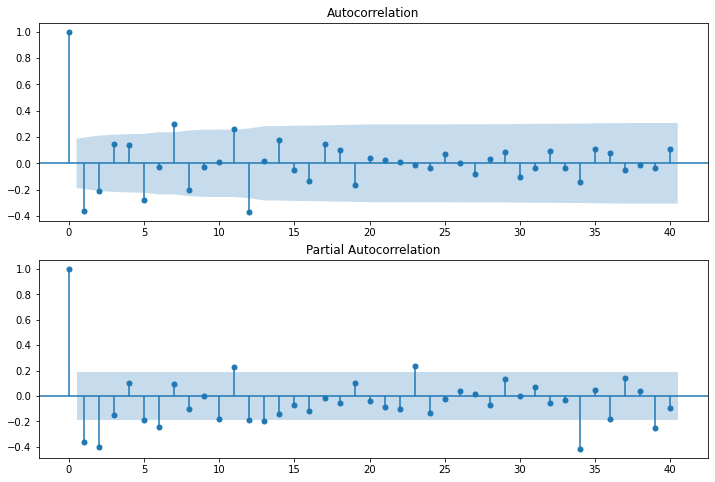

In [22]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pre_covid.seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pre_covid.seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

In [23]:
mod = sm.tsa.statespace.SARIMAX(pre_covid.AirPassengers, trend='n', order=(0,1,1), seasonal_order=(0,1,1,12))
results = mod.fit()
print (results.summary())

C:\Users\bmrmo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\bmrmo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                      AirPassengers   No. Observations:                  122
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  39.893
Date:                            Wed, 12 May 2021   AIC                            -73.786
Time:                                    12:55:57   BIC                            -65.712
Sample:                                01-01-2010   HQIC                           -70.511
                                     - 02-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6962      0.077     -9.073      0.000      -0.847      -0.546
ma.S.L12      -0.3751      0.112   

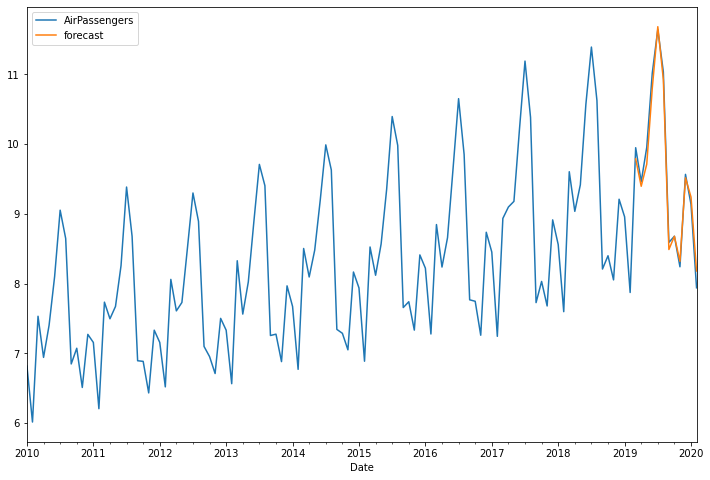

In [24]:
pre_covid['forecast'] = results.predict(start = 110, end= 121, dynamic= True)  
pre_covid[['AirPassengers', 'forecast']].plot(figsize=(12, 8)) 
plt.savefig('ts_df_predict.png', bbox_inches='tight')

In [25]:
pre_covid.tail(15)

,AirPassengers,first_difference,seasonal_first_difference,forecast
Date,,,,
2018-12-01,9.209221,1.156538,-0.077886,NaN
2019-01-01,8.956997,-0.252224,0.101328,NaN
2019-02-01,7.872131,-1.084866,-0.122070,NaN
2019-03-01,9.948135,2.076004,0.069112,9.788764
2019-04-01,9.461086,-0.487049,0.081194,9.395191
2019-05-01,9.952955,0.491869,0.111384,9.711237
2019-06-01,11.018680,1.065725,-0.087527,10.801820
2019-07-01,11.644596,0.625916,-0.196219,11.683662
2019-08-01,11.035622,-0.608974,0.157764,10.924257


In [26]:
from sklearn.metrics import r2_score
y_true = [9.948135,9.461086,9.952955,11.01868,11.644596,11.035622,8.589987,8.6783,8.24063,9.566028,9.135555,7.939127]
y_pred = [9.788763,9.39519,9.711236,10.801818,11.68366,10.924256,8.488317,8.678714,8.317937,9.516519,9.240113,8.179852]
r2_score(y_true, y_pred)

0.9844351438082218